In [1]:
import numpy as np
import matplotlib.pylab as plot
from astropy.io import ascii,fits
from scipy import interpolate
import grb_catalogs_copy
from BurstCube.LocSim.Detector import *
from BurstCube.LocSim.Spacecraft import *
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.optimize import curve_fit
import math

In [2]:
# read in GBM GRB catalog (first 9 years)
gbm=fits.open('gbmgrbcat_copy.fits')
gbm=gbm[1].data

#randomly select GRBs from GBM catalog in orer to create simulated sample

simsample = gbm[np.random.choice(gbm.shape[0], 6352, replace=True)]


In [3]:
## code to use when reading in GBM effective area in order to get data into the desired format
def getGBMdata(gbmfile=None):
    """Reads the GBM NaI effective area file and returns a numpy array
    with two columns ``energy`` and ``aeff``.
    Parameters
    ----------
    gbmfile : string
       Name of file that contains the GBM data.
    Returns
    ----------
    gbmdata : array 
    numpy array with two columns ``energy`` and ``aeff``
    """
    
    return np.genfromtxt(gbmfile,skip_header=2,names=('energy', 'aeff'))


In [4]:
## bit of useful code for interpolating in log space
def loginterpol(x,y,x1):

    f=interpolate.interp1d(np.log10(x),np.log10(y),bounds_error=False,fill_value="extrapolate",kind='linear')
    y1=10**f(np.log10(x1))

    return y1

def loginterpol2d(x,y,z,x1,y1):

    wz=np.where(z==0)[0]
    zz=z
    zz[wz]=1.
    f=interpolate.interp2d(x,y,np.log10(zz),bounds_error=False,fill_value="extrapolate",kind='linear')
    z1=10**f(x1,y1)

In [5]:
## generate random positions on the sky with equal area probability
def random_sky(n=1):

    u=np.random.rand(n)
    v=np.random.rand(n)

    phi=2*np.pi*u
    theta=np.arccos(2*v-1.)

    dec=-np.degrees(theta-np.pi/2.)
    ra=np.degrees(np.pi*2-phi)

    return ra,dec

In [6]:
## read in the GBM Aeff
aeff_gbm = getGBMdata('/home/alyson/NASA/Simulation/BurstCube/Users/ajoens/gbm_effective_area.dat')

In [7]:
## separate GBM short & long GRBs
w=np.where(gbm['FLUX_1024']>0)
gbm=gbm[w]
s=np.where(gbm['T90'] <= 2.)[0]
l=np.where(gbm['T90'] > 2.)[0]
m=np.where(gbm['PFLX_BEST_FITTING_MODEL'][s] == ' ')


In [8]:
#Integrating the best fit spectrum for each GRB in the energy range of 50-300 KeV to get max. observed photon flux. 
#This will give us the photon flux in units of ph/cm^2/s. Currently only doing this for GBM and will then add in BurstCube
# the parts below I have commented out are what I believe are for BC and currently I am focusing on GBM
mo=gbm['PFLX_BEST_FITTING_MODEL'][s]
#f=np.zeros([len(s),nsims]) # produces an array of zeros with the given shape and type
pf=np.zeros(len(s))
gbmcr=np.zeros(len(s))
outE=np.logspace(np.log10(50),np.log10(300),100) # returns numbers spaced evenly on a log scale
for i in range(len(s)):
    #for j in range(nsims):
        #E=np.array(eng[w[j]+1:w[j+1]+1])
        #AeffBC=loginterpol(E,aeffs['aeff'][w[j]+1:w[j+1]+1],outE)
        AeffGBM=loginterpol(aeff_gbm['energy'],aeff_gbm['aeff'],outE)#eng[w[j]+1:w[j+1]+1])
        #Aratio=(AeffBC/AeffGBM)
        # not sure what *grb_catalogs_copy.pl(outE,gbm['PFLX_PLAW_INDEX'][s[i]] is and why we need it. I think we only need the model photon flux times the aeffGBM and we want it integrated over the energy range provided in outE
        # this should give us an array of the maximum observed photon flux for GBM
        if mo[i]=='PFLX_PLAW':
            gbmcr[i]=np.trapz(gbm['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs_copy.pl(outE,gbm['PFLX_PLAW_INDEX'][s[i]])*AeffGBM,outE)
            pf[i]=np.trapz(gbm['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs_copy.pl(outE,gbm['PFLX_PLAW_INDEX'][s[i]]),outE)
            #pf[i]=gbm['PFLX_PLAW_PHTFLUX'][s[i]]
        if mo[i]=='PFLX_COMP':
            gbmcr[i]=np.trapz(gbm['PFLX_COMP_AMPL'][s[i]]*grb_catalogs_copy.comp(outE,gbm['PFLX_COMP_INDEX'][s[i]],gbm['PFLX_COMP_EPEAK'][s[i]])*AeffGBM,outE)
            pf[i]=np.trapz(gbm['PFLX_COMP_AMPL'][s[i]]*grb_catalogs_copy.comp(outE,gbm['PFLX_COMP_INDEX'][s[i]],gbm['PFLX_COMP_EPEAK'][s[i]]),outE)
            #pf[i]=gbm['PFLX_COMP_PHTFLUX'][s[i]]
        if mo[i]=='PFLX_BAND':
            gbmcr[i]=np.trapz(gbm['PFLX_BAND_AMPL'][s[i]]*grb_catalogs_copy.band(outE,gbm['PFLX_BAND_ALPHA'][s[i]],gbm['PFLX_BAND_EPEAK'][s[i]],gbm['PFLX_BAND_BETA'][s[i]])*AeffGBM,outE)
            pf[i]=np.trapz(gbm['PFLX_BAND_AMPL'][s[i]]*grb_catalogs_copy.band(outE,gbm['PFLX_BAND_ALPHA'][s[i]],gbm['PFLX_BAND_EPEAK'][s[i]],gbm['PFLX_BAND_BETA'][s[i]]),outE)
            #pf[i]=gbm['PFLX_BAND_PHTFLUX'][s[i]]
        if mo[i]=='PFLX_SBPL':
            gbmcr[i]=np.trapz(gbm['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs_copy.sbpl(outE,gbm['PFLX_SBPL_INDX1'][s[i]],gbm['PFLX_SBPL_BRKEN'][s[i]],gbm['PFLX_SBPL_INDX2'][s[i]])*AeffGBM,outE)
            pf[i]=np.trapz(gbm['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs_copy.sbpl(outE,gbm['PFLX_SBPL_INDX1'][s[i]],gbm['PFLX_SBPL_BRKEN'][s[i]],gbm['PFLX_SBPL_INDX2'][s[i]]),outE)
            #pf[i]=gbm['PFLX_SBPL_PHTFLUX'][s[i]]

pf = np.array(pf)
gbmcr = np.array(gbmcr)
#print(pf)
sizepf =np.shape(pf)
print(sizepf)

(394,)


In [20]:
#Finding the peak flux and count rate of our simulated sample.
ms=simsample['PFLX_BEST_FITTING_MODEL'][s]
#f=np.zeros([len(s),nsims]) # produces an array of zeros with the given shape and type
simpf=np.zeros(len(s))
simgbmcr=np.zeros(len(s))
outE=np.logspace(np.log10(50),np.log10(300),100) # returns numbers spaced evenly on a log scale
for i in range(len(s)):
    #for j in range(nsims):
        #E=np.array(eng[w[j]+1:w[j+1]+1])
        #AeffBC=loginterpol(E,aeffs['aeff'][w[j]+1:w[j+1]+1],outE)
        AeffGBM=loginterpol(aeff_gbm['energy'],aeff_gbm['aeff'],outE)#eng[w[j]+1:w[j+1]+1])
        #Aratio=(AeffBC/AeffGBM)
        # not sure what *grb_catalogs_copy.pl(outE,gbm['PFLX_PLAW_INDEX'][s[i]] is and why we need it. I think we only need the model photon flux times the aeffGBM and we want it integrated over the energy range provided in outE
        # this should give us an array of the maximum observed photon flux for GBM
        if ms[i]=='PFLX_PLAW':
            simgbmcr[i]=np.trapz(simsample['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs_copy.pl(outE,simsample['PFLX_PLAW_INDEX'][s[i]])*AeffGBM,outE)
            simpf[i]=np.trapz(simsample['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs_copy.pl(outE,simsample['PFLX_PLAW_INDEX'][s[i]]),outE)
        if ms[i]=='PFLX_COMP':
            simgbmcr[i]=np.trapz(simsample['PFLX_COMP_AMPL'][s[i]]*grb_catalogs_copy.comp(outE,simsample['PFLX_COMP_INDEX'][s[i]],simsample['PFLX_COMP_EPEAK'][s[i]])*AeffGBM,outE)
            simpf[i]=np.trapz(simsample['PFLX_COMP_AMPL'][s[i]]*grb_catalogs_copy.comp(outE,simsample['PFLX_COMP_INDEX'][s[i]],simsample['PFLX_COMP_EPEAK'][s[i]]),outE)
            #pf[i]=gbm['PFLX_COMP_PHTFLUX'][s[i]]
        if ms[i]=='PFLX_BAND':
            simgbmcr[i]=np.trapz(simsample['PFLX_BAND_AMPL'][s[i]]*grb_catalogs_copy.band(outE,simsample['PFLX_BAND_ALPHA'][s[i]],simsample['PFLX_BAND_EPEAK'][s[i]],simsample['PFLX_BAND_BETA'][s[i]])*AeffGBM,outE)
            simpf[i]=np.trapz(simsample['PFLX_BAND_AMPL'][s[i]]*grb_catalogs_copy.band(outE,simsample['PFLX_BAND_ALPHA'][s[i]],simsample['PFLX_BAND_EPEAK'][s[i]],simsample['PFLX_BAND_BETA'][s[i]]),outE)
            #pf[i]=gbm['PFLX_BAND_PHTFLUX'][s[i]]
        if ms[i]=='PFLX_SBPL':
            simgbmcr[i]=np.trapz(simsample['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs_copy.sbpl(outE,simsample['PFLX_SBPL_INDX1'][s[i]],simsample['PFLX_SBPL_BRKEN'][s[i]],simsample['PFLX_SBPL_INDX2'][s[i]])*AeffGBM,outE)
            simpf[i]=np.trapz(simsample['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs_copy.sbpl(outE,simsample['PFLX_SBPL_INDX1'][s[i]],simsample['PFLX_SBPL_BRKEN'][s[i]],simsample['PFLX_SBPL_INDX2'][s[i]]),outE)
            #pf[i]=gbm['PFLX_SBPL_PHTFLUX'][s[i]]

simpf = np.array(simpf)
simgbmcr = np.array(simgbmcr)
#print(pf)
sizepf =np.shape(simpf)
print(sizepf)

IndexError: index 394 is out of bounds for axis 0 with size 394

(394,)


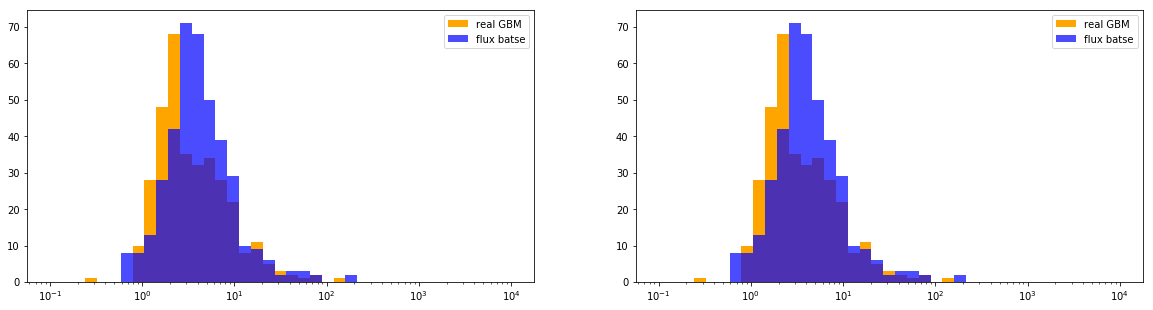

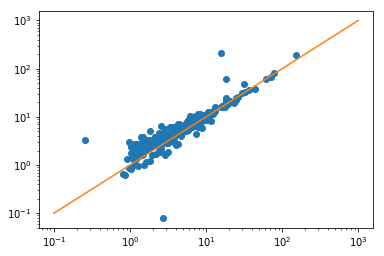

In [10]:
#plot Batse[64] against pf to see if they are the same
flux=gbm['FLUX_BATSE_64'][s]
fluxshape=np.shape(flux)
print(fluxshape)

#Creating plot of peak flux versus counts for real and simulated GBM
#print(np.log10(pf[w]))
fig=plot.figure(figsize=(20,5))
plot.subplot(1,2,1)
plot.hist(pf,label='real GBM',bins=np.logspace(-1,4,40),color='orange')
plot.hist(flux,label='flux batse',bins=np.logspace(-1,4,40),alpha=0.7,color='blue')
plot.xscale('log')
plot.legend()
plot.subplot(1,2,2)
#plot.hist(flux,label='All',bins=np.logspace(-1,2,40),color='green')
#pf has been gathered from the GBM catalog
plot.hist(pf,label='real GBM',bins=np.logspace(-1,4,40),color='orange')
# this is the simulated GBM
plot.hist(flux,label='flux batse',bins=np.logspace(-1,4,40),alpha=0.7,color='blue')
#plot.hist(flux[w],label='BC',bins=np.logspace(-1,2,40),alpha=0.7,color='red')
plot.xscale('log')
plot.legend()

plot.show()

plot.plot(pf,flux, linestyle='None', marker='o')
plot.xscale('log')
plot.yscale('log')
plot.plot([1e-1,1e3],[1e-1,1e3])
plot.show()

In [11]:
# we want to solve for the number of detected counts. We need to create two more arrays- 1 for exposure and the other for interval.
#Interval is given in the GBM catalog however we need to know exposure. This should be found from the exposure map for each burst.
#this all together will give us the number of source photons

## setup GBM
gbm_pointings = {'01': ('45:54:0','20:36:0'),
            '02': ('45:6:0','45:18:0'),
            '03': ('58:24:0','90:12:0'),
            '04': ('314:54:0','45:12:0'),
            '05': ('303:12:0','90:18:0'),
            '06': ('3:24:0','89:48:0'),
            '07': ('224:54:0','20:24:0'),
            '08': ('224:36:0','46:12:0'),
            '09': ('236:36:0','90:0:0'),
            '10': ('135:12:0','45:36:0'),
            '11': ('123:42:0','90:24:0'),
            '12': ('183:42:0','90:18:0')}

fermi = Spacecraft(gbm_pointings,window=0.1)

res = 250
rr,dd = np.meshgrid(np.linspace(0,360,res,endpoint=False),np.linspace(-90,90,res))
exposure_positions = np.vstack([rr.ravel(),dd.ravel()])
gbm_exposures = np.array([[ detector.exposure(position[0],position[1]) for position in exposure_positions.T] 
                      for detector in fermi.detectors])

In [12]:
#using SkyCoord to convert coordinates to degrees and solve for distances.
def separation(ra1,dec1,ra2,dec2):

    c=SkyCoord(ra=ra1*u.deg,dec=dec1*u.deg)
    d=SkyCoord(ra=ra2*u.deg,dec=dec2*u.deg)
    dist=c.separation(d)
    dist=dist.value

    return dist

In [13]:
# now that GBM's pointings are set up we will throw GRBs at it and determine it's exposure for each GRB. 
#generate GRBs and throw them at GBM

def throw_grbs(fermi,minflux,maxflux):
    
    nsims=int(np.round(len(simgbmcr))) #why is nsims length of pf*2?
    ra,dec=random_sky(nsims)
    ra=np.array(ra)-180
    dec=np.array(dec)
    #sigma=0.65,mean=1.5
 
    #change the sigma and mean in order to create a log fit for simulated GBM. Automate this fit.
    #flux=np.random.lognormal(size=nsims,sigma=0.55,mean=0.6)*(np.log10(maxflux)-np.log10(minflux))+np.log10(minflux)

    #GBM exposures for each random GRB. Believe this is an array with the different exposures for each detector
    randgbmexposures = np.array([[detector.exposure(ra[i],dec[i]) for i in range(nsims)] for detector in fermi.detectors])
    print("randgbmexposures=", randgbmexposures)

    #Order randgbmexposures into descending order
    for column in randgbmexposures.T:
        newrandgbm = -np.sort(-randgbmexposures.T) 
    gbmexposures = np.transpose(newrandgbm)
    print("gbmexposures=",gbmexposures)

    #Select the second highest value. 
    #We will use this to ensure the second highest exposure detector has a sig >4.5
    secondhighest = gbmexposures[1,:]
    print("Second highest =", secondhighest)

        
    return gbmexposures, secondhighest, randgbmexposures

In [14]:
#define the peak flux interval
interval = simsample['PFLX_SPECTRUM_STOP']-simsample['PFLX_SPECTRUM_START']
print(interval)
#interval = gbm['PFLX_SPECTRUM_STOP'][s]-gbm['PFLX_SPECTRUM_START'][s]
#print the interval of only the short bursts
#print(interval[s])
w=np.shape(interval)
print(w)


[1.024 1.024 1.024 ... 1.024 1.024 1.024]
(6352,)


In [15]:
#flux=simpf this is in ph/sec
flux=simpf
minflux=min(flux)
maxflux=max(flux)
gbmexposures, secondhighest, randgbmexposures = throw_grbs(fermi,minflux,maxflux)

sechighestsize=np.shape(secondhighest)
print(sechighestsize)
#execute function defined above
#throw_grbs(fermi,minflux,maxflux,pf)

randgbmexposures= [[0.0970838  0.         0.45854817 ... 0.         0.8988282  0.        ]
 [0.         0.         0.40064338 ... 0.         0.97774093 0.        ]
 [0.07376012 0.         0.62757451 ... 0.         0.81030922 0.        ]
 ...
 [0.90195658 0.         0.91267678 ... 0.         0.         0.        ]
 [0.91999472 0.         0.94463557 ... 0.         0.10670995 0.        ]
 [0.7561461  0.         0.25036343 ... 0.         0.         0.07661192]]
gbmexposures= [[0.91999472 0.99236579 0.94463557 ... 0.         0.97774093 0.8414408 ]
 [0.90195658 0.92069391 0.91267678 ... 0.         0.8988282  0.8300274 ]
 [0.7561461  0.50195432 0.62757451 ... 0.         0.81030922 0.7154714 ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Second highest = [0.90195658 0.92069391 0.91267678 0.88634197 0.82869186 0.
 0. 

In [16]:
#Solve for the number of detected counts which will equal our source photons
#Should this really be multiplied by pf or should it be multiplied by flux? pf is calculated from GBM catalog#
source = simpf*secondhighest*interval[s]
q=np.shape(simpf)
print(q)
y=np.shape(secondhighest)
print(y)
x=np.shape(interval[s])
print(x)

(394,)
(394,)
(394,)


In [17]:
#Assuming a background count rate. units: cts/s
bckgrd= 1000
#scale the background count rate 
scaledbckgrd = bckgrd*secondhighest*interval[s]
print(scaledbckgrd)

[ 923.60353314  942.79056021  934.58102027  907.61417762  848.58046098
    0.            0.            0.            0.           54.50861602
  628.47342852   55.67589517  824.51384915  765.47083692    0.
  735.37548221    0.            0.           56.79915475  982.71875931
   36.37200214    0.            0.           50.97776138    0.
    0.            0.            0.          905.34563345  949.87882701
  803.78253054    0.            0.            0.          904.06381491
    0.            0.          835.53505875  953.76099388  911.26385171
  888.19649522  803.21899465  939.80284844    0.          769.22818518
    0.            0.            0.            0.          986.04895175
    0.          935.6538904   974.0031476   905.67363247  770.29223916
   61.28857462  846.13483569    0.          482.51316095    0.
  833.98923262  805.78063448  868.17514048  841.42627594  792.37780362
    0.          945.76587613    0.          766.61353161    0.
  843.35823519    0.          849.7235

In [18]:
#calculate the significance of the second highest exposure detector. If the significance is greater than 4.5 sigma than the burst is detectable.
#creating an array of zeros that I can 
detect = np.zeros(len(secondhighest))
for i in range(len(secondhighest)):
    sig = source[i] / (math.sqrt(source[i] + scaledbckgrd[i]))
    if sig > 4.5:
        detect[i] = 1.0
    else:
        detect[i] = 0.0

print(detect)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

/home/alyson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


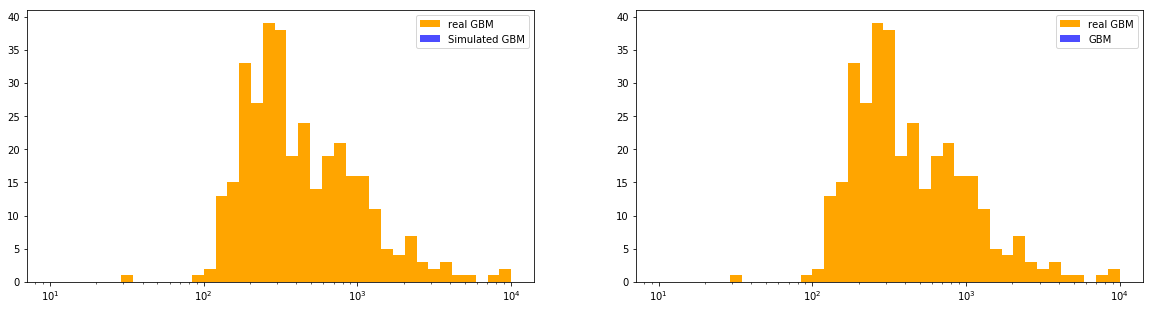

In [19]:
#Creating plot of peak flux versus counts for real and simulated GBM
w=np.where(pf>0)[0]
wg = np.where(simgbmcr*detect>0)[0]
#print(np.log10(pf[w]))
fig=plot.figure(figsize=(20,5))
plot.subplot(1,2,1)
plot.hist(gbmcr[w],label='real GBM',bins=np.logspace(1,4,40),color='orange')
plot.hist(simgbmcr[wg],label='Simulated GBM',bins=np.logspace(1,4,40),alpha=0.7,color='blue')
plot.xscale('log')
plot.legend()
plot.subplot(1,2,2)
#plot.hist(flux,label='All',bins=np.logspace(-1,2,40),color='green')
#pf has been gathered from the GBM catalog
plot.hist(gbmcr[w],label='real GBM',bins=np.logspace(1,4,40),color='orange')
# this is the simulated GBM
plot.hist(simgbmcr[wg],label='GBM',bins=np.logspace(1,4,40),alpha=0.7,color='blue')
#plot.hist(flux[w],label='BC',bins=np.logspace(-1,2,40),alpha=0.7,color='red')
plot.xscale('log')
plot.legend()

plot.show()
        